## TensorFlow Probabilityでベイズ構造時系列モデル


In [1]:
%load_ext lab_black

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

np.random.seed(0)

2021-12-09 04:56:11.992868: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-09 04:56:11.992964: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
print("TensorFlow", tf.__version__)
print("TensorFlow Probability", tfp.__version__)

TensorFlow 2.7.0
TensorFlow Probability 0.15.0


In [4]:
def create_data(t, n_observed):
    tn = len(t)
    ti = np.r_[:tn]
    trend = 0.025 * ti
    interc = 10
    obs_noise = np.random.normal(0, 0.5, tn)

    s = np.sin(ti * np.pi / 3) + np.sin(ti * np.pi / 6) + trend + interc
    y = s + obs_noise

    return s, y, (t[:n_observed], y[:n_observed]), (t[n_observed:], y[n_observed:])

all=300, observed=240, forecast=60


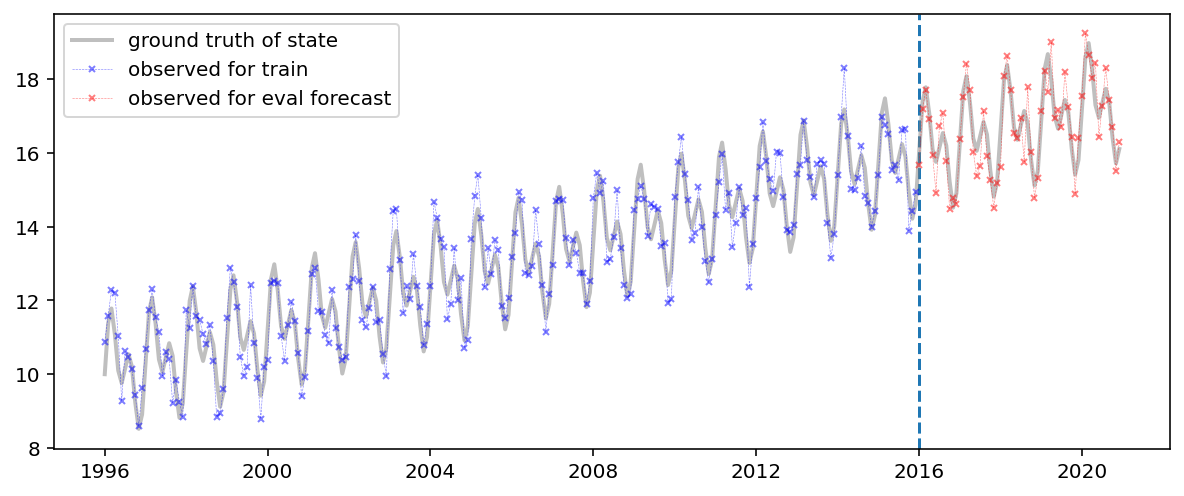

In [5]:
t = np.arange("1996-01", "2021-01", dtype="datetime64[M]")
tn = len(t)
n_observed = int(tn * 0.8)
n_forecast = tn - n_observed
t_now = t[n_observed]
print(f"all={tn}, observed={n_observed}, forecast={n_forecast}")

state, y, (t_observed, y_observed), (t_forecast, y_forecast) = create_data(
    t, n_observed
)

plt.figure(figsize=(10, 4))
plt.axvline(t_now, linestyle="--")
plt.plot(t, state, lw=2, color="gray", alpha=0.5, label="ground truth of state")
plt.plot(
    t_observed,
    y_observed,
    marker="x",
    markersize=3,
    ls="--",
    lw=0.3,
    color="b",
    alpha=0.5,
    label="observed for train",
)
plt.plot(
    t_forecast,
    y_forecast,
    marker="x",
    markersize=3,
    ls="--",
    lw=0.3,
    color="r",
    alpha=0.5,
    label="observed for eval forecast",
)
plt.legend()
plt.show()

In [6]:
def build_model(observed_time_series):
    """ローカル線形トレンド＋季節性モデル"""
    return tfp.sts.Sum(
        [
            tfp.sts.LocalLinearTrend(observed_time_series=observed_time_series),
            tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series),
        ],
        observed_time_series=observed_time_series,
    )

tfp.stsモジュールに構造時系列用の機能が含まれています。tfp.sts.Sumで複数のコンポーネントを組み合わせることが可能です。ここでは疑似データの特徴がわかりきっているので、そのままローカル線形トレンドと12個周期の季節効果をモデル化します。

In [7]:
model = build_model(y_observed)

Instructions for updating:
Do not call `graph_parents`.


2021-12-09 04:56:21.558048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-09 04:56:21.558741: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-09 04:56:21.558972: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f3c9176525ca): /proc/driver/nvidia/version does not exist
2021-12-09 04:56:21.560104: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


変分近似事後分布を求めます。

In [8]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=model)

### ELBOの最小化
変分損失関数ELBO（Evidence Lower BOund）をAdamで最小化します。tfp.viモジュールに変分推論のための機能が含まれています。

In [9]:
num_steps = int(200)
optimizer = tf.optimizers.Adam(learning_rate=0.1)


@tf.function(jit_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=model.joint_log_prob(observed_time_series=y_observed),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_steps,
    )
    return elbo_loss_curve

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-12-09 04:56:34.183704: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x562050edf180 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-12-09 04:56:34.183800: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-12-09 04:56:34.572241: W tensorflow/compiler/tf2xla/kernels/random_ops.cc:102] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. fit_surrogate_posterior/sanitize_seed/seed
2021-12-09 04:56:34.588257: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:237] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2021-12-09 04:56:53.174264: I tensorflow/compiler/jit/xla_compilation_cache.cc:351] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


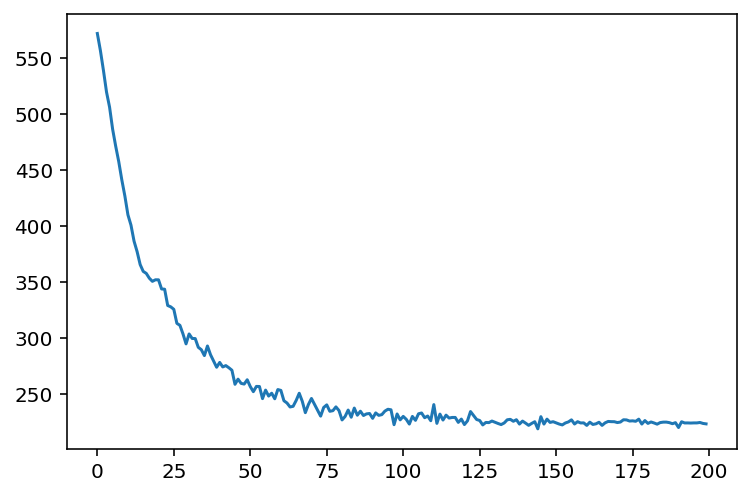

CPU times: user 31.7 s, sys: 522 ms, total: 32.2 s
Wall time: 31.8 s


In [10]:
%%time
elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

推定事後分布のサンプルから推定パラメータを確認

In [11]:
ps_vi = variational_posteriors.sample(50)

In [12]:
def print_params(parameter_samples):
    for name, value in parameter_samples.items():
        print(
            f"{name:40}: {np.mean(value, axis=0):.2f}"
            + f" ± {np.std(value, axis=0):.2f}"
        )


print_params(ps_vi)

observation_noise_scale                 : 0.47 ± 0.02
LocalLinearTrend/_level_scale           : 0.02 ± 0.01
LocalLinearTrend/_slope_scale           : 0.00 ± 0.00
Seasonal/_drift_scale                   : 0.03 ± 0.02


### Forecast

In [13]:
def forecast(model, observed_time_series, parameter_samples, num_steps_forecast):
    dist = tfp.sts.forecast(
        model,
        observed_time_series=observed_time_series,
        parameter_samples=parameter_samples,
        num_steps_forecast=num_steps_forecast,
    )

    loc = dist.mean()[..., 0]
    scale = dist.stddev()[..., 0]
    samples = dist.sample(10)[..., 0]
    return dist, loc, scale, samples

In [14]:
dist, loc, scale, samples = forecast(model, y_observed, ps_vi, n_forecast)

In [15]:
def score(y, p):
    se = np.power(y - p, 2)
    mse = np.mean(se)
    r2 = np.power(np.corrcoef(y, p)[0, 1], 2)
    return mse, r2


def plot_score(y, s, p):
    def pos(co, r):
        a, b = co
        return a + (b - a) * r

    mse, r2 = score(y, p)
    mse_s, r2_s = score(s, p)
    print(f"       mse: {mse:7.4f}, R2: {r2:7.4f}")
    print(f" state mse: {mse_s:7.4f}, R2: {r2_s:7.4f}")

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(p, y)
    plt.xlabel("forecast")
    plt.ylabel("ground truth observed")
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.text(pos(xlim, 0.1), pos(ylim, 0.9), f"mse={mse:.4f}\n$R^2$={r2:.4f}")
    plt.plot(xlim, ylim, c="gray")
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.subplot(1, 2, 2)
    plt.scatter(p, s)
    plt.xlabel("forecast")
    plt.ylabel("ground truth state")
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.text(pos(xlim, 0.1), pos(ylim, 0.9), f"mse={mse_s:.4f}\n$R^2$={r2_s:.4f}")
    plt.plot(xlim, ylim, c="gray")
    plt.xlim(xlim)
    plt.ylim(ylim)


def plot_forecast_results(
    t_observed,
    y_observed,
    t_forecast,
    y_forecast,
    t,
    state,
    forecast_samples,
    forecast_mean,
    forecast_scale,
    num_step_forecast,
):
    plt.figure(figsize=(10, 5))
    plt.axvline(t_forecast[0], linestyle="--")
    plt.plot(t, state, lw=2, color="gray", alpha=0.5, label="ground truth of state")
    plt.plot(
        t_observed,
        y_observed,
        marker="x",
        markersize=3,
        ls="--",
        lw=0.3,
        color="b",
        alpha=0.5,
        label="observed",
    )
    plt.plot(
        t_forecast,
        tf.transpose(forecast_samples),
        lw=0.6,
        ls="--",
        color="r",
        alpha=0.1,
    )
    plt.plot(
        t_forecast, forecast_mean, lw=1, ls="-", color="r", alpha=1, label="forecast"
    )
    plt.fill_between(
        t_forecast,
        forecast_mean - 2 * forecast_scale,
        forecast_mean + 2 * forecast_scale,
        color="r",
        alpha=0.1,
    )
    plt.legend()

       mse:  0.2710, R2:  0.8245
 state mse:  0.0226, R2:  0.9826


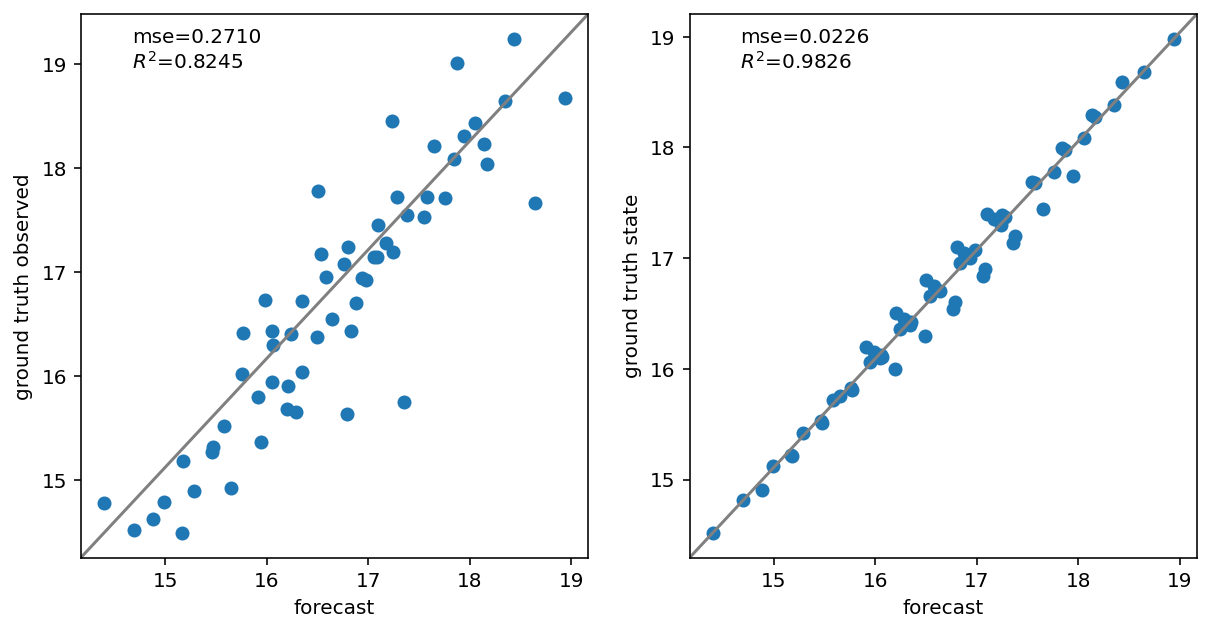

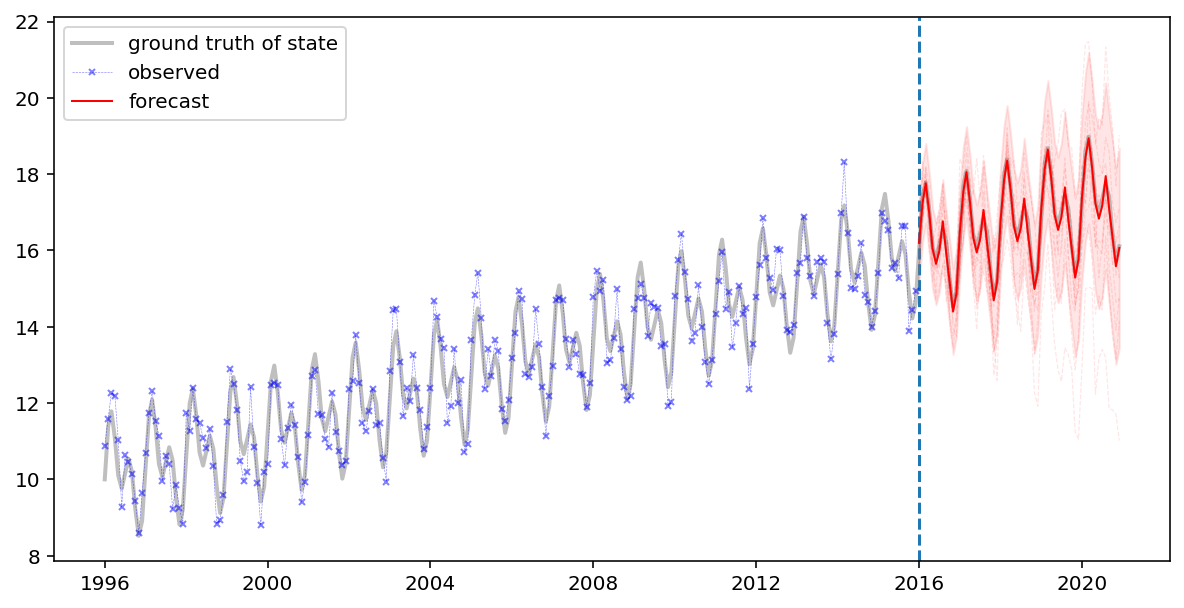

In [16]:
plot_score(y[n_observed:], state[n_observed:], loc)
plt.show()
plot_forecast_results(
    t_observed,
    y_observed,
    t_forecast,
    y_forecast,
    t,
    state,
    samples,
    loc,
    scale,
    n_forecast,
)
plt.show()

### コンポーネント分解

In [17]:
def get_components(model, observed_time_series, parameter_samples, forecast_dist):
    # 観測分 component dists for observed
    o = tfp.sts.decompose_by_component(
        model,
        observed_time_series=observed_time_series,
        parameter_samples=parameter_samples,
    )
    means_o = {k.name: c.mean() for k, c in o.items()}
    stddevs_o = {k.name: c.stddev() for k, c in o.items()}

    # 予測分
    f = tfp.sts.decompose_forecast_by_component(
        model, forecast_dist=forecast_dist, parameter_samples=parameter_samples
    )
    means_f = {k.name: c.mean() for k, c in f.items()}
    stddevs_f = {k.name: c.stddev() for k, c in f.items()}

    # 観測分と予測分をキー毎に結合
    def concat_per_key(dicts, keys=None):
        if keys is None:
            keys = dicts[0].keys()
        return {k: tf.concat([d[k] for d in dicts], axis=0) for k in keys}

    means = concat_per_key([means_o, means_f])
    stddevs = concat_per_key([stddevs_o, stddevs_f])
    return means, stddevs

In [18]:
means, stddevs = get_components(model, y_observed, ps_vi, dist)

In [19]:
def plot_components(t, means, stddevs, vline=None):
    N = len(means)
    fig = plt.figure(figsize=(12, 3 * N))
    for i, name in enumerate(means.keys()):
        mean = means[name]
        stddev = stddevs[name]
        ax = fig.add_subplot(N, 1, 1 + i)
        if vline is not None:
            ax.axvline(vline, ls="--", c="b", lw=2, alpha=0.5)
        ax.plot(t, mean, lw=2)
        ax.fill_between(t, mean - 2 * stddev, mean + 2 * stddev, alpha=0.2)
        ax.set_title(name)
    fig.autofmt_xdate()
    fig.tight_layout()

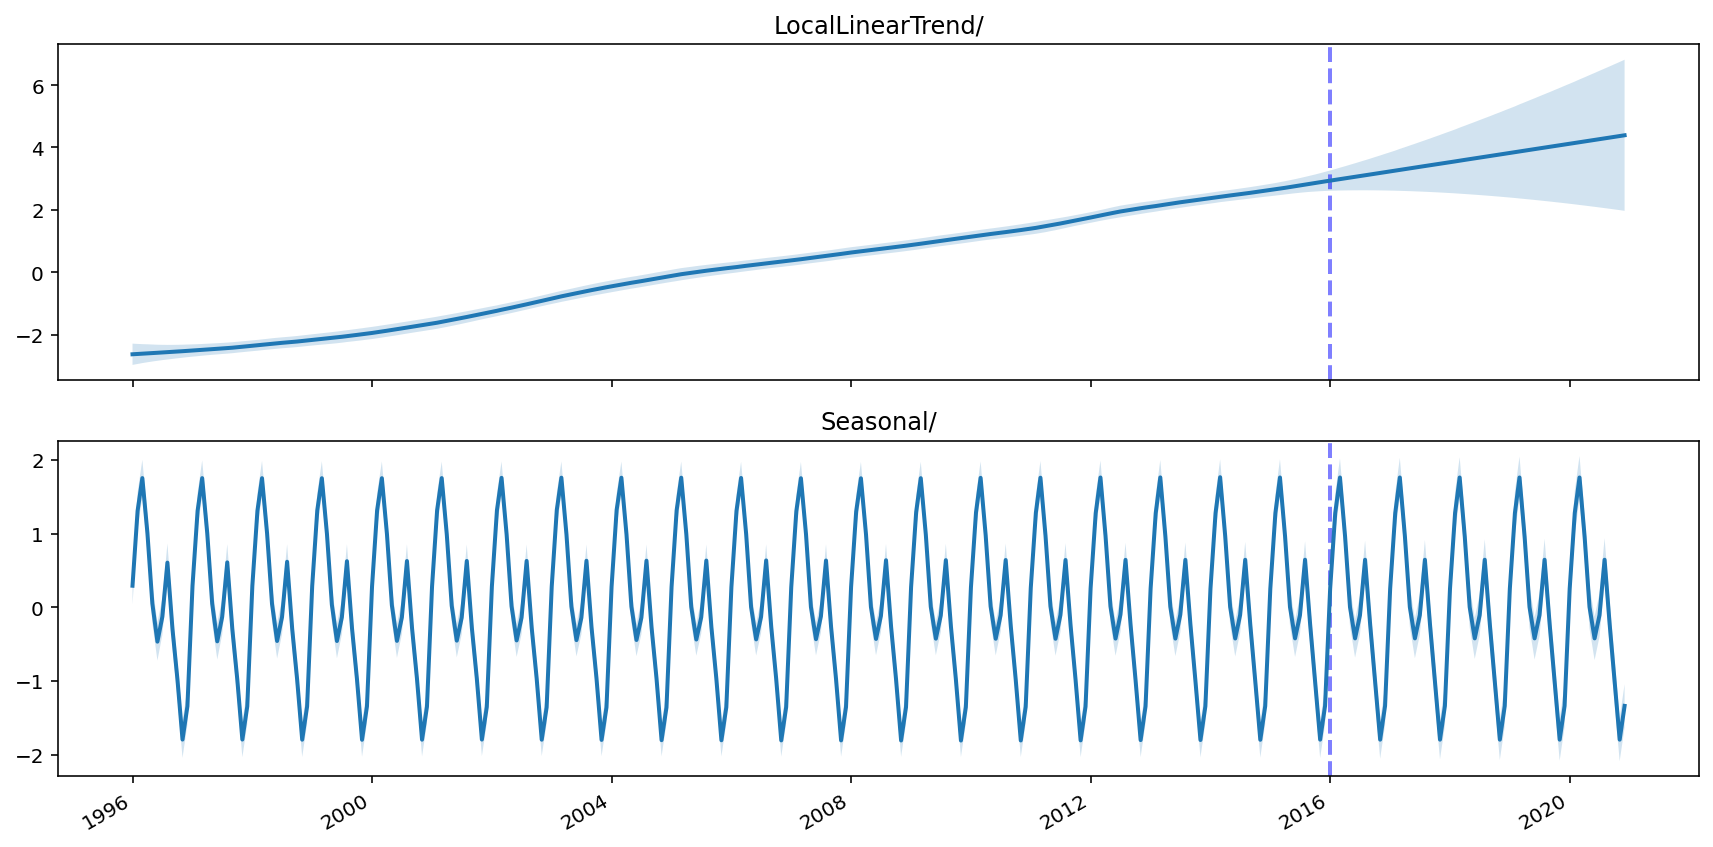

In [20]:
plot_components(t, means, stddevs, t_now)
plt.show()

In [21]:
def forecast_and_plot(
    model,
    parameter_samples,
    t_observed,
    y_observed,
    t_forecast,
    y_forecast,
    t,
    state,
    num_steps_forecast,
):
    """ここまでの処理をまとめた"""
    print_params(parameter_samples)

    dist, loc, scale, samples = forecast(
        model, y_observed, parameter_samples, num_steps_forecast
    )

    plot_score(y_forecast, state[len(t_observed) :], loc)
    plt.show()
    plot_forecast_results(
        t_observed,
        y_observed,
        t_forecast,
        y_forecast,
        t,
        state,
        samples,
        loc,
        scale,
        num_steps_forecast,
    )
    plt.show()
    means, stddevs = get_components(model, y_observed, parameter_samples, dist)
    plot_components(t, means, stddevs, t_forecast[0])
    plt.show()

### HMC
ついでにHMC（ハミルトニアンモンテカルロ法）を用いて事後分布からサンプルを取得してみましょう。ここではパラメータは調整せずに実行してみす。変分推論に比べてかなり時間がかかります。

In [22]:
%%time
model2 = build_model(y_observed)
samples_hmc, kernel_results = tfp.sts.fit_with_hmc(model2, y_observed)

/tmp/Python/python-3.9.9/lib/python3.9/site-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


CPU times: user 15min 29s, sys: 1min 3s, total: 16min 33s
Wall time: 10min 39s


In [23]:
print(
    f"Acceptance Rate: {np.mean(kernel_results.inner_results.inner_results.is_accepted, axis=0):.2%}"
)

Acceptance Rate: 96.00%


observation_noise_scale                 : 0.47 ± 0.02
LocalLinearTrend/_level_scale           : 0.02 ± 0.02
LocalLinearTrend/_slope_scale           : 0.00 ± 0.00
Seasonal/_drift_scale                   : 0.01 ± 0.01
       mse:  0.2742, R2:  0.8225
 state mse:  0.0255, R2:  0.9809


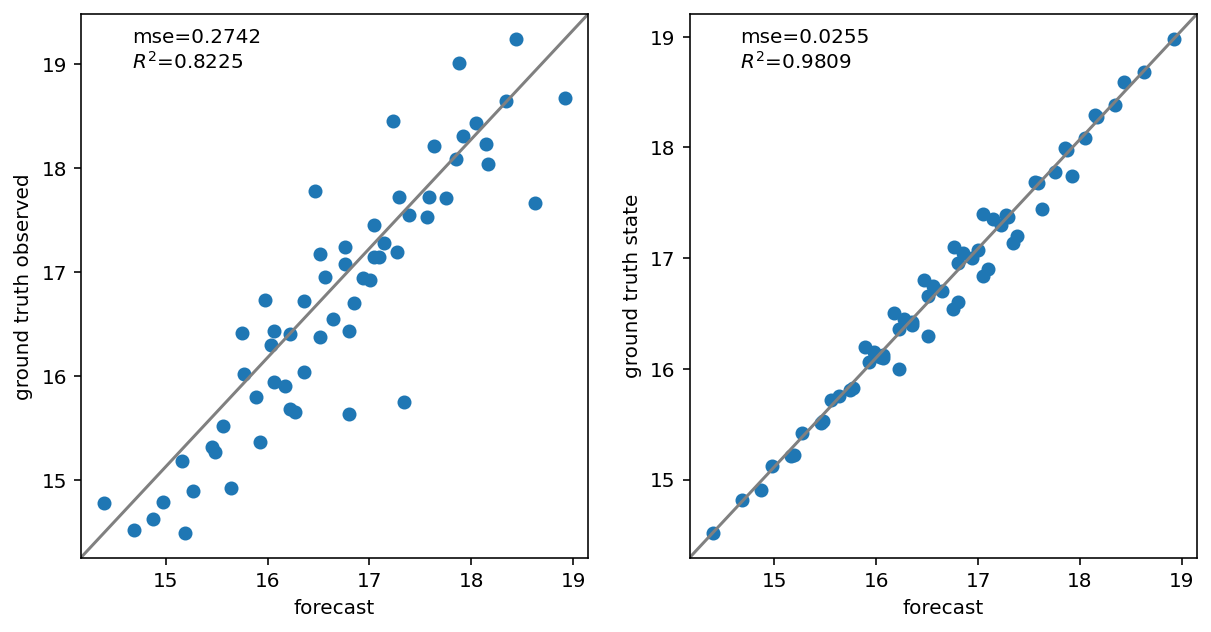

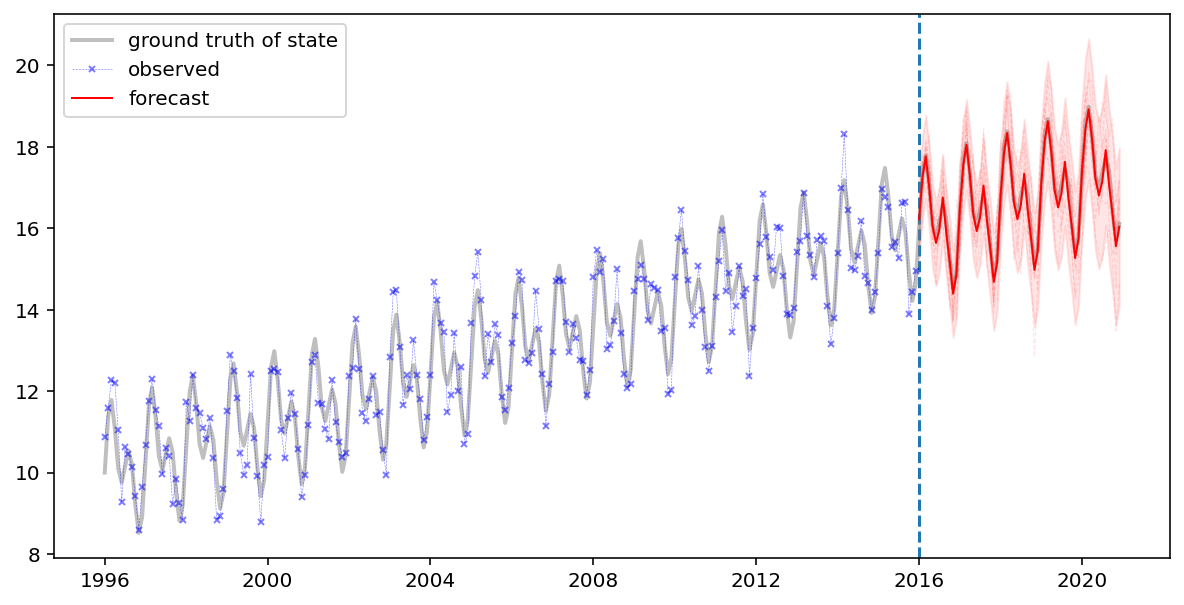

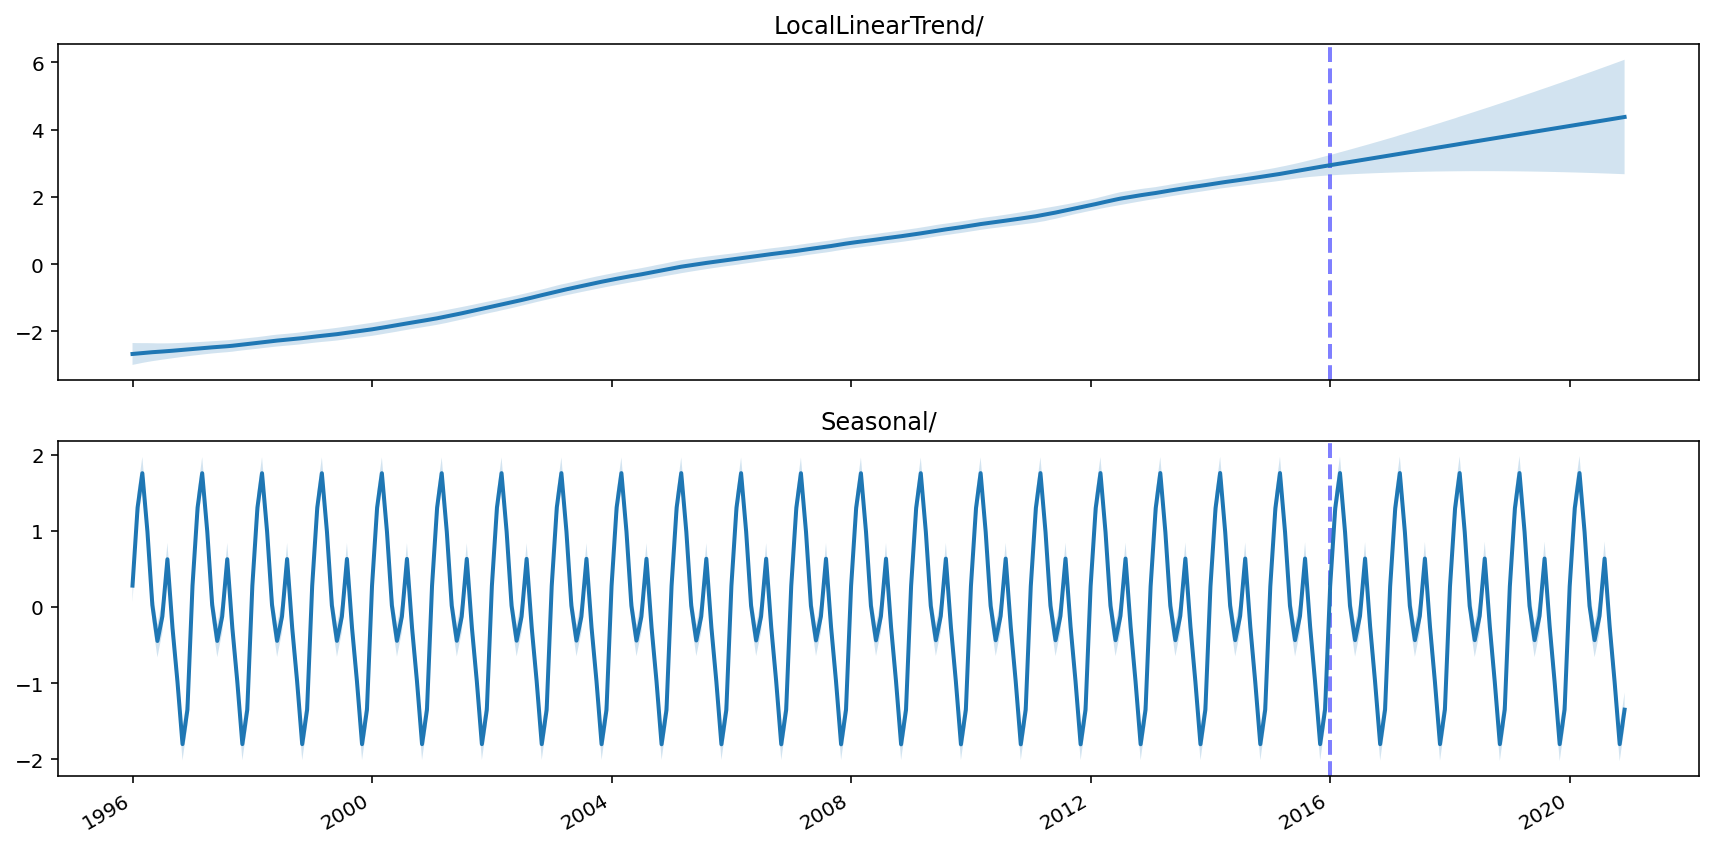

In [24]:
ps_hmc = {p.name: v for p, v in zip(model2.parameters, samples_hmc)}
forecast_and_plot(
    model2, ps_hmc, t_observed, y_observed, t_forecast, y_forecast, t, state, n_forecast
)